In [1]:
import gym
import numpy as np
import time
import random 


from bokeh.plotting import figure, show
from bokeh.io import output_notebook

output_notebook()

env_name = 'FrozenLake-v1'


Loading BokehJS ...

In [2]:
def render_single(env, policy, max_steps=100):
    """
    Renders policy for an environment.

    Parameters
    ----------
    env:    gym.core.Environment, open gym environment object
    policy: np.array of shape [env.nS], the action to take at a given state
    """
    episode_reward = 0
    ob = env.reset()
    for t in range(max_steps):
        env.render()
        time.sleep(0.25)
        a = policy[ob]
        ob, reward, done, _ = env.step(a)
        episode_reward += reward
        if done:
            break
    env.render();
    if not done:
        print("The agent didn't reach a terminal state in {} steps.".format(max_steps))
    else:
        print("Episode reward: %f" % episode_reward)

In [3]:
class Visualizer:
    pass


class Evaluator:
    def __init__(self):
        self.__sum_of_rewards_per_episode = [0]
        self.__episode_len = [0]

    def log_metrics_per_episode(self, reward, episode):
        """Logs sum of rewards per episode and episode length."""
        if (episode + 1) > len(self.__sum_of_rewards_per_episode):
            self.__sum_of_rewards_per_episode.append(0)
            self.__episode_len.append(0)
        self.__sum_of_rewards_per_episode[episode] += reward
        self.__episode_len[episode] += 1

    @property
    def sum_of_rewards_per_episode(self):
        return self.__sum_of_rewards_per_episode
    
    @property
    def episode_len(self):
        return self.__episode_len


class QLearning:
    '''Implements Off-policy control with Q Learning.'''

    def __init__(self, env, num_states, num_actions, alpha, epsilon, gamma):
        '''Parameters
        ----------
        env:         gym.core.Environment, open gym environment object
        num_states:  integer, number of states in the environment
        num_actions: integer, number of possible actions
        alpha:       float, step size, (0, 1]
        epsilon:     float, the epsilon parameter used for exploration
        gamma:       float, discount factor, small > 0
        '''
        self.env = env
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma

        self.Q = np.zeros((self.num_states, self.num_actions))

        self.env.reset()

    def run_q_learning(self, num_episodes, evaluator, verbose=True):
        '''Runs Q learning

        Parameters
        ----------
        num_episodes: integer, number of episodes to run to train RL agent

        Returns
        ----------
        self.policy:         list of integers of length self.num_states, final policy
        '''
        terminated = False
        for i in range(num_episodes):
            self.env.reset()
            state = np.random.choice(self.num_states, 1)[0]
            terminated = False
            while not terminated:
                action, next_state, reward, terminated = self.generate_next_step(state)
                evaluator.log_metrics_per_episode(reward, i)
                if not isinstance(next_state, int):
                    raise TypeError('Integer is expected as a next state')
                self.evaluate_policy(state, action, reward, next_state)

                state = next_state

        # Once training is finished, calculate and return policy using argmax approach
        final_policy = np.argmax(self.Q, axis=1)

        return final_policy

    def generate_next_step(self, state):
        '''Generates action in state and outcome (next_state, reward, terminated)of taking this action.

        Parameters
        ----------
        state: int, current state of the agent

        Returns
        ----------
        action:      int, action that agent takes in state
        observation: object, observation as a result of agent taking action in state, format is specific to the environment
        reward:      float
        terminated:  bool, whether a terminal state (as defined under the MDP of the task) is reached.
        '''
        random_action = self.env.action_space.sample()
        action = self.get_epsilon_greedy_action(state, random_action)

        observation, reward, terminated, _ = self.env.step(action)

        return (action, observation, reward, terminated)

    def evaluate_policy(self, state, action, reward, next_state):
        '''Updates Q value for a specific state and action pair.

        Parameters
        ----------
        state:      int, current state
        action:     int, action taken in state
        reward:     float, reward as a result of taking action in state
        next_state: int
        '''
        est_reward = reward + self.gamma * np.max(self.Q[next_state])
        self.Q[state][action] = self.Q[state][action] + self.alpha * (est_reward - self.Q[state][action])

    def argmax(self, state: int) -> int:
        """
        Finds and returns greedy action.

        Parameters
        ----------
        state: int, state for which greedy action should be selected

        Returns
        ----------
        action: int, corresponds to the index of the greedy action

        """
        return int(np.argmax(self.Q[state]))

    def get_epsilon_greedy_action(self, state, random_action):
        '''Returns next action using epsilon greedy approach.

        Parameters
        ----------
        state:         int, current state
        random_action: int, action sampled from current state

        Returns
        ----------
        next_action: int, either greedy or random action
        '''
        prob = np.random.random()

        if prob < (1 - self.epsilon):
            return self.argmax(state)

        return random_action

# Tests

In [13]:
import ipytest
import pytest
ipytest.autoconfig()

In [62]:
%%ipytest -qq

np.random.seed(1)
 
@pytest.fixture
def this_env():
    env = gym.make('FrozenLake-v1', is_slippery=False)
    env.seed(0)
    
    yield env

@pytest.fixture
def q_learning_instance(this_env):
    alpha = 1
    epsilon = 0.8
    gamma = 1
    num_states = this_env.observation_space.n
    num_actions = this_env.action_space.n
    yield QLearning(this_env, num_states, num_actions, alpha, epsilon, gamma)
    

def test_argmax(q_learning_instance):
    res = q_learning_instance.argmax(0)
    assert isinstance(res, int)
    assert res == 0
    
    
def test_get_epsilon_greedy_action(q_learning_instance):
    action = q_learning_instance.get_epsilon_greedy_action(0, 3)
    assert isinstance(action, int)
    action == 0
  
    
def test_argmax(this_env, q_learning_instance):
    action = q_learning_instance.argmax(1)
    assert action < this_env.observation_space.n
    assert action >= 0

    
def test_evaluate_policy(this_env, q_learning_instance):
    q_learning_instance.Q = np.zeros((q_learning_instance.num_states, q_learning_instance.num_actions))
    q_learning_instance.Q[1][3] = 10
    
    state = 2
    action = 1
    reward = 5
    next_state = 1
    
    q_learning_instance.evaluate_policy(state, action, reward, next_state)
    assert q_learning_instance.Q[state][action] == 15
    

...                                                                                          [100%]


# Frozen lake

In [5]:
np.random.seed(1)

alpha = 0.1
epsilon = 0.9
gamma = 0.9
n_episodes = 1000

env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)
env.seed(11)
np.random.seed(1)
num_states = env.observation_space.n
num_actions = env.action_space.n
print(f"Starting environment with {num_states} states and {num_actions} actions")

# set_random_seeds(env)
model = QLearning(env, num_states, num_actions, alpha, epsilon, gamma)
evaluator = Evaluator()
policy = model.run_q_learning(n_episodes, evaluator)


Starting environment with 16 states and 4 actions


In [6]:
policy

array([1, 2, 1, 0, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2])

In [7]:
model.Q

array([[0.27523398, 0.31123183, 0.29827673, 0.2742791 ],
       [0.27176277, 0.19650226, 0.33595717, 0.29435678],
       [0.28045553, 0.37925442, 0.26576834, 0.31547602],
       [0.31207192, 0.1170276 , 0.23321279, 0.23958644],
       [0.30079479, 0.35400067, 0.20044309, 0.27360618],
       [0.15716351, 0.12549712, 0.22260444, 0.12564398],
       [0.15588838, 0.44498007, 0.18337756, 0.29297465],
       [0.15515015, 0.18769528, 0.12492389, 0.13066075],
       [0.33693558, 0.18787211, 0.40208691, 0.3023778 ],
       [0.31956875, 0.45317915, 0.45385766, 0.15070495],
       [0.36013414, 0.56264949, 0.15651242, 0.31723114],
       [0.13595144, 0.18978946, 0.15861673, 0.05594715],
       [0.1308662 , 0.14290964, 0.21452116, 0.17176044],
       [0.15129136, 0.38154514, 0.50988124, 0.30951945],
       [0.41852469, 0.46790685, 0.89765725, 0.36753231],
       [0.11592848, 0.13494799, 0.18575545, 0.14879949]])

In [68]:
render_single(env, policy, 200)


SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Episode reward: 1.000000


In [70]:
evaluator.sum_of_rewards_per_episode
evaluator.episode_len

[19,
 3,
 13,
 16,
 23,
 7,
 3,
 27,
 7,
 4,
 6,
 3,
 5,
 19,
 3,
 5,
 7,
 17,
 9,
 10,
 6,
 3,
 18,
 8,
 19,
 6,
 16,
 6,
 3,
 5,
 10,
 4,
 11,
 10,
 26,
 4,
 9,
 11,
 15,
 20,
 11,
 6,
 6,
 7,
 17,
 8,
 5,
 7,
 4,
 5,
 12,
 12,
 2,
 5,
 5,
 14,
 15,
 18,
 9,
 3,
 13,
 9,
 6,
 3,
 13,
 6,
 2,
 10,
 2,
 3,
 4,
 9,
 19,
 8,
 16,
 7,
 8,
 13,
 6,
 15,
 21,
 12,
 4,
 4,
 6,
 14,
 9,
 2,
 8,
 5,
 5,
 7,
 6,
 6,
 3,
 11,
 5,
 15,
 7,
 10,
 11,
 6,
 4,
 7,
 14,
 24,
 8,
 4,
 19,
 5,
 12,
 2,
 3,
 13,
 14,
 4,
 17,
 2,
 7,
 5,
 11,
 8,
 2,
 4,
 3,
 12,
 5,
 17,
 2,
 10,
 13,
 7,
 6,
 6,
 3,
 4,
 8,
 7,
 2,
 12,
 34,
 3,
 3,
 6,
 10,
 7,
 6,
 6,
 7,
 9,
 2,
 15,
 3,
 8,
 2,
 6,
 6,
 2,
 46,
 17,
 9,
 3,
 3,
 12,
 6,
 4,
 5,
 2,
 3,
 5,
 9,
 5,
 6,
 3,
 5,
 3,
 3,
 9,
 4,
 3,
 7,
 11,
 4,
 4,
 5,
 6,
 4,
 2,
 2,
 8,
 7,
 4,
 14,
 6,
 7,
 5,
 5,
 5,
 20,
 3,
 4,
 12,
 11,
 10,
 8,
 6,
 8,
 5,
 4,
 7,
 10,
 2,
 3,
 9,
 18,
 3,
 4,
 2,
 10,
 2,
 3,
 5,
 3,
 9,
 5,
 18,
 2,
 11,
 10,
 2,
 14,
 5,
 

In [55]:
p = figure(
    title="Sum of rewards",
    plot_width=800,
    plot_height=250,
    x_axis_label="Episodes",
    y_axis_label="Average sum of rewards during episode"
)
p.line(range(1, n_episodes + 1), evaluator.sum_of_rewards_per_episode, line_width=1)

show(p)

In [71]:
p = figure(
    title="Episode Length",
    plot_width=800,
    plot_height=250,
    x_axis_label="Episodes",
    y_axis_label="Length"
)
p.line(range(1, n_episodes + 1), evaluator.episode_len, line_width=1)

show(p)

<AxesSubplot: >

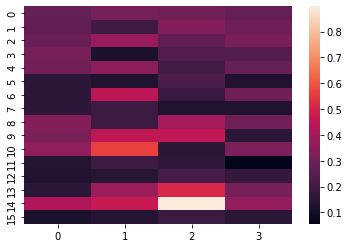

In [8]:
import seaborn
seaborn.heatmap(model.Q)

# Cliff Walking

In [56]:


np.random.seed(1)

alpha = 0.1
epsilon = 0.9
gamma = 0.9
n_episodes = 1000

env = gym.make('CliffWalking-v0')
env.seed(11)
np.random.seed(1)
num_states = env.observation_space.n
num_actions = env.action_space.n
print(f"Starting environment with {num_states} states and {num_actions} actions")

set_random_seeds(env)
model = QLearning(env, num_states, num_actions, alpha, epsilon, gamma)

evaluator = Evaluator()
policy = model.run_q_learning(n_episodes, evaluator)

Starting environment with 48 states and 4 actions


In [28]:
render_single(env, policy, 200)

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o

In [57]:
p = figure(
    title="Sum of rewards",
    plot_width=800,
    plot_height=250,
    x_axis_label="Episodes",
    y_axis_label="Average sum of rewards during episode"
)
p.line(range(1, n_episodes + 1), evaluator.sum_of_rewards_per_episode, line_width=1)

show(p)

# Taxi Problem

In [58]:
np.random.seed(1)

alpha = 0.1
epsilon = 0.9
gamma = 0.9
n_episodes = 1000

env = gym.make('Taxi-v3')
env.seed(11)
np.random.seed(1)
num_states = env.observation_space.n
num_actions = env.action_space.n
print(f"Starting environment with {num_states} states and {num_actions} actions")

set_random_seeds(env)
model = QLearning(env, num_states, num_actions, alpha, epsilon, gamma)

evaluator = Evaluator()
policy = model.run_q_learning(n_episodes, evaluator)

Starting environment with 500 states and 6 actions


In [30]:
render_single(env, policy, 200)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | :_:G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | :_: |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |

In [59]:
p = figure(
    title="Sum of rewards",
    plot_width=800,
    plot_height=250,
    x_axis_label="Episodes",
    y_axis_label="Average sum of rewards during episode"
)
p.line(range(1, n_episodes + 1), evaluator.sum_of_rewards_per_episode, line_width=1)

show(p)

# Evaluation

In [ ]:
# sum of rewards during the episode +
# average episode length +
# heatmap of Q matrix
# heatmap for exploration: how frequently each state and action are visited? -> maximization bias and double learning

# check same metrics for different hyperparameters